In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import importlib

import src.preprocessing
importlib.reload(src.preprocessing)
from src.preprocessing import PreProcessClass


- Still need to understand why the mean value reduce with years
- Understand pick NaN values around Christmas 2023

In [2]:
sys.path.append(str(Path("Alpiq ETHdatathon challenge 2025").resolve()))
from data import DataLoader, SimpleEncoding
input_path = "Alpiq ETHdatathon challenge 2025/datasets2025/"
loader = DataLoader(input_path)
consumptions, features, example_solution = loader.load_data("IT")

preprocessor_it = PreProcessClass(consumptions, features)

# Pick all customer columns
col_customers_it = [id for id in consumptions.columns if id.startswith("VALUEMWHMETERINGDATA_customerIT")]
data_it = preprocessor_it.preprocess_EDA(col_customers_it)

In [3]:
sys.path.append(str(Path("Alpiq ETHdatathon challenge 2025").resolve()))
from data import DataLoader, SimpleEncoding
input_path = "Alpiq ETHdatathon challenge 2025/datasets2025/"
loader = DataLoader(input_path)
consumptions, features, example_solution = loader.load_data("ES")

preprocessor_es = PreProcessClass(consumptions, features)

# Pick all customer columns
col_customers_es = [id for id in consumptions.columns if id.startswith("VALUEMWHMETERINGDATA_customerES")]
data_es = preprocessor_es.preprocess_EDA(col_customers_es)

In [4]:
def plot_basic(df, col, title):
    """
    Plots a time series line chart using Plotly.
    """

    fig = px.line(
        df,
        x=df.index,     # Time on x-axis
        y=col,          # Column to plot
        title=title,
        height=500,
        width=1000,
        labels={col: 'Value', 'index': 'Time'}
    )

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Value",
    )

    fig.show()

def plot_aggregated_consumption(df, group_by, title):
    """
    Function to plot the aggregated consumption data.
    """
    agg_df = df.groupby(group_by, as_index=False, observed = True).agg({'MeanConsumption': 'mean'})
    
    if group_by[1] == "Dow":
        # Order the days of the week
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        agg_df['Dow'] = pd.Categorical(agg_df['Dow'], categories=day_order, ordered=True)
        agg_df = agg_df.sort_values(['Dow', group_by[0]])

    # Plot
    fig = px.line(
        agg_df,
        x=group_by[0],
        y='MeanConsumption',
        title=title,
        color = group_by[1] if len(group_by) > 1 else None,
        height=500,
        width=1000,
    )

    fig.update_layout(
        xaxis_title=group_by[0],
        yaxis_title='Mean Energy Demand [MW]',
        legend_title=group_by[1] if len(group_by) > 1 else None
    )
    
    fig.show()

def plot_aggregated_consumption_day(df, group_by, title):
    """
    Function to plot the aggregated consumption data and highlight the month of August.
    """
    agg_df = df.groupby(group_by, as_index=False, observed=True).agg({'MeanConsumption': 'mean'})
    
    # Plot
    fig = px.line(
        agg_df,
        x=group_by[0],
        y='MeanConsumption',
        title=title,
        color=group_by[1] if len(group_by) > 1 else None,
        height=500,
        width=1000,
    )

    fig.update_layout(
        xaxis_title=group_by[0],
        yaxis_title='Mean Energy Demand [MW]',
        legend_title=group_by[1] if len(group_by) > 1 else None
    )
    
    if group_by[0] == "DayYear":
        # Highlight the month of August
        fig.add_vrect(x0=214, x1=245, fillcolor="black", opacity=0.1, line_width=0, annotation_text="August", annotation_position="top left")
        fig.add_vline(x=214, line_width=3, line_dash="dash", line_color="black")
        fig.add_vline(x=245, line_width=3, line_dash="dash", line_color="black")


    fig.show()

# EDA: Italy

### **New Features**

Part 1:

- **ActivePartDay**: (6am-8pm)
- **IsWeekendSpecial**: Saturday 8pm to Monday 6 am
  
Part 2:

- **SpecialCustomer**: Customers active on weekends and during the night

-----

### Part 1:

In [5]:
plot_basic(data_it,"temp","Temperature over time")
plot_basic(data_es,"temp","Temperature over time")

### 

There is an increase of customers over the years, which imply a decrease value of missing value over time.

In [6]:
missing_data_it = data_it.isna().sum(axis=1).to_frame(name = "Missing Values")
missing_data_it = missing_data_it.loc[missing_data_it.index < "2024-08-01"]
plot_basic(missing_data_it,"Missing Values","Missing Values Over Time: Italy")

missing_data_es = data_es.isna().sum(axis=1).to_frame(name = "Missing Values")
missing_data_es = missing_data_es.loc[missing_data_es.index < "2024-08-01"]
plot_basic(missing_data_es,"Missing Values","Missing Values Over Time: Spain")

### Check **Day|Year|Season|Month** effect w.r.t Hour

**Italy**:
- We see the demand is higher on the weekend and during the active part of the day (6am-8pm).

**Spain**:
- We see the demand is higher on the weekend and during the active part of the day (6am-8pm).

In [7]:
data_it["MeanConsumption"] = data_it[col_customers_it].mean(axis=1)
df_it = data_it.drop(columns = col_customers_it)

data_es["MeanConsumption"] = data_es[col_customers_es].mean(axis=1)
df_es = data_es.drop(columns = col_customers_es)

In [8]:
plot_aggregated_consumption(df_it, ["Hour", "Dow"], "Mean Energy Demand by Hour and Day of Week")
plot_aggregated_consumption(df_es, ["Hour", "Dow"], "Mean Energy Demand by Hour and Day of Week")

In [9]:
plot_aggregated_consumption(df_it, ['Hour', 'Season'], 'Mean Hourly Power Demand per Season')
plot_aggregated_consumption(df_es, ['Hour', 'Season'], 'Mean Hourly Power Demand per Season')

In [10]:
plot_aggregated_consumption(df_it, ['Hour','Year'], 'Mean Hourly Power Demand per Year')
plot_aggregated_consumption(df_es, ['Hour','Year'], 'Mean Hourly Power Demand per Year')

In [11]:
plot_aggregated_consumption(df_it, ['Hour','Month'], 'Mean Hourly Power Demand per Month')
plot_aggregated_consumption(df_es, ['Hour','Month'], 'Mean Hourly Power Demand per Month')

In [12]:
plot_aggregated_consumption_day(df_it, ['DayYear','Year'], 'Mean Hourly Power Demand per Month')
plot_aggregated_consumption_day(df_es, ['DayYear','Year'], 'Mean Hourly Power Demand per Month')

### Part 2:

**Check Difference values of customers over every weekend**

In [13]:
data_2023_it = data_it.loc["2023-01-01":"2023-12-31"]

df_2023_weekend_it = data_2023_it[data_2023_it["IsWeekendSpecial"] == True ]
df_2023_week_it = data_2023_it[data_2023_it["IsWeekendSpecial"] == False ]
df_2023_night_it = data_2023_it[data_2023_it["ActiveDay"] == False ]

WeeklyWeekend_means = (df_2023_weekend_it
                .groupby(["Week", "IsWeekendSpecial"])[col_customers_it]
                .mean()
                .reset_index()
                )
WeeklyWeek_means = (df_2023_week_it
                .groupby(["Week", "IsWeekendSpecial"])[col_customers_it]
                .mean()
                .reset_index()
                )

WeeklyNight_means = (df_2023_night_it
                .groupby(["Week", "ActiveDay"])[col_customers_it]
                .mean()
                .reset_index()
                )


WeeklyWeekend_means = WeeklyWeekend_means.set_index("Week")
WeeklyWeek_means = WeeklyWeek_means.set_index("Week")
WeeklyNight_means = WeeklyNight_means.set_index("Week")

weekend_long = WeeklyWeekend_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
weekend_long["Period"] = "Weekend"

week_long = WeeklyWeek_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
week_long["Period"] = "Week"

night_long = WeeklyNight_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
night_long["Period"] = "Night"

# Step 2: Concatenate
combined_df = pd.concat([weekend_long, week_long, night_long], ignore_index=True)

# Step 2: Concatenate
combined_df = pd.concat([weekend_long, week_long, night_long], ignore_index=True)

unique_customers = combined_df["Customer"].unique()
customer_map = {col: f"Customer {i+1}" for i, col in enumerate(unique_customers)}
combined_df["CustomerName"] = combined_df["Customer"].map(customer_map)



C:\Users\jean-\AppData\Local\Temp\ipykernel_44616\1343255046.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\jean-\AppData\Local\Temp\ipykernel_44616\1343255046.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\jean-\AppData\Local\Temp\ipykernel_44616\1343255046.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [14]:
customer_active_weekend_it = []
customer_active_week_it = []
customer_active_night_it = []

for col in enumerate(col_customers_it):
    if WeeklyWeekend_means[col[1]].mean() >= 1:
        customer_active_weekend_it.append(col[1])
    if WeeklyWeek_means[col[1]].mean() >= 1:
        customer_active_week_it.append(col[1])
    if WeeklyNight_means[col[1]].mean() >= 1:
        customer_active_night_it.append(col[1])

special_customers_it = list(set(customer_active_weekend_it + customer_active_week_it + customer_active_night_it))
normal_customers_it = list(set(col_customers_it) - set(special_customers_it))

print(f"There are {len(special_customers_it)} special customers in the period 2023")

There are 31 special customers in the period 2023


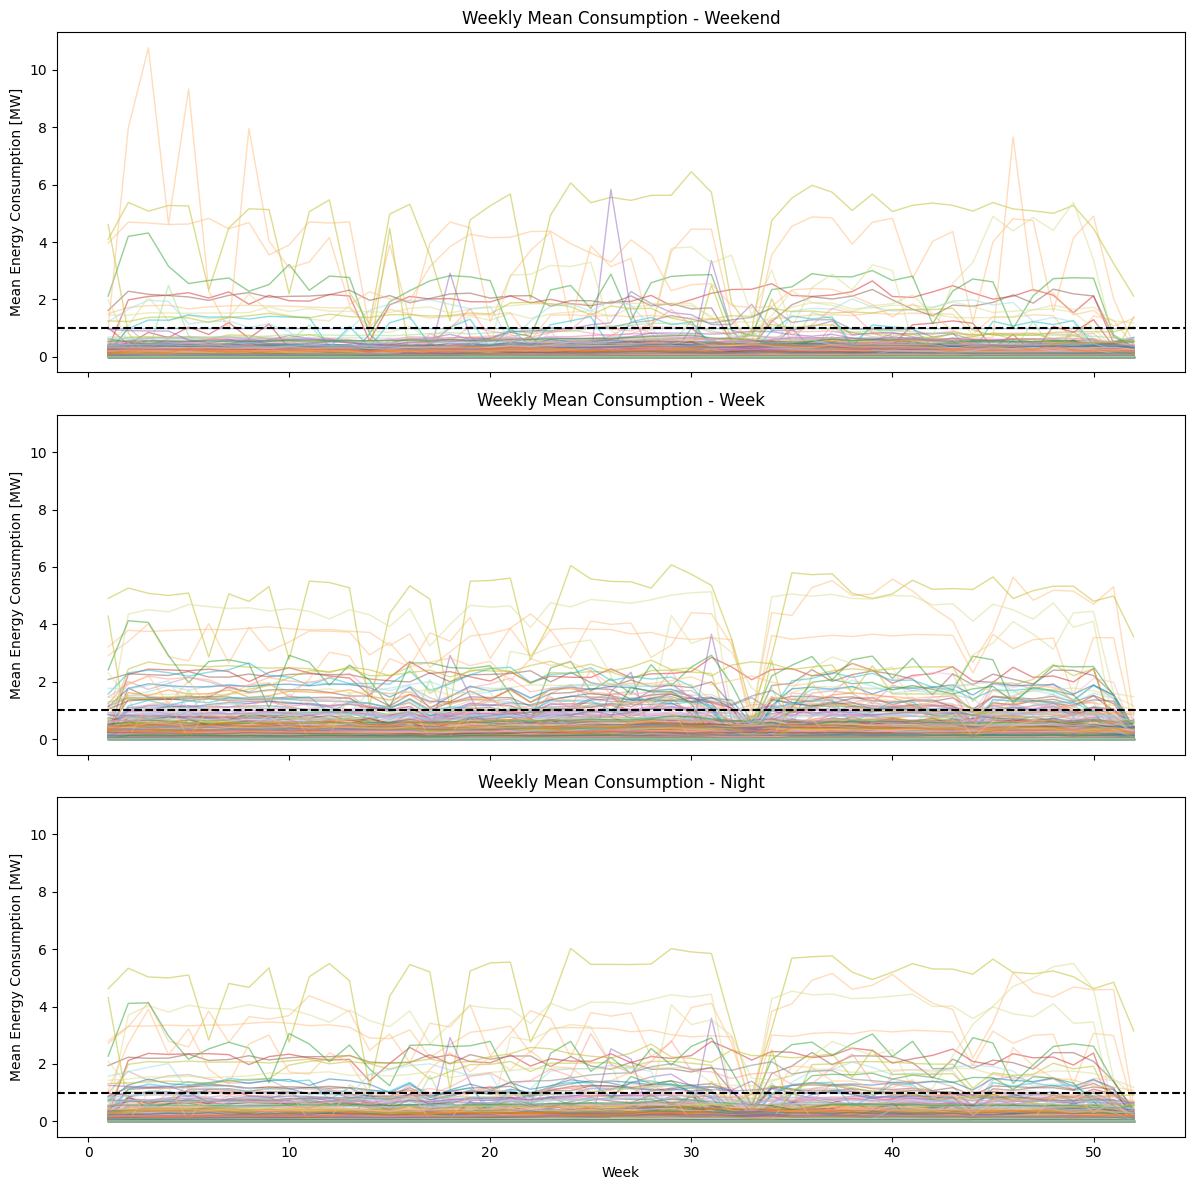

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True, sharey=True)

periods = ["Weekend", "Week", "Night"]
colors = plt.cm.tab20.colors  # general colors for customers

# Create a stable color mapping to customers excluding special_customers
all_customers = combined_df['CustomerName'].unique()
regular_customers = [cust for cust in all_customers if cust not in special_customers_it]
color_mapping = {customer: colors[i % len(colors)] for i, customer in enumerate(regular_customers)}

for i, period in enumerate(periods):
    subset = combined_df[combined_df["Period"] == period]
    for customer, group in subset.groupby("CustomerName"):
        if customer in special_customers_it:
            axs[i].plot(
                group["Week"],
                group["MeanConsumption"],
                label=customer,
                color='red',
                alpha=2,
                linewidth=10,
                zorder=5  # to plot on top
            )
        else:
            axs[i].plot(
                group["Week"],
                group["MeanConsumption"],
                label=customer,
                color=color_mapping[customer],
                alpha=0.5,
                linewidth=1
            )

    axs[i].axhline(y=1, color="black", linestyle="--", label="Threshold")
    axs[i].set_title(f"Weekly Mean Consumption - {period}")
    axs[i].set_ylabel("Mean Energy Consumption [MW]")

axs[-1].set_xlabel("Week")

# Optional legend: Place outside plot area clearly
handles, labels = axs[0].get_legend_handles_labels()

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # add space for legend
plt.show()


In [16]:
data_2023_es = data_es.loc["2023-01-01":"2023-12-31"]

df_2023_weekend_es = data_2023_es[data_2023_es["IsWeekendSpecial"] == True ]
df_2023_week_es = data_2023_es[data_2023_es["IsWeekendSpecial"] == False ]
df_2023_night_es = data_2023_es[data_2023_es["ActiveDay"] == False ]

WeeklyWeekend_means = (df_2023_weekend_es
                .groupby(["Week", "IsWeekendSpecial"])[col_customers_es]
                .mean()
                .reset_index()
                )
WeeklyWeek_means = (df_2023_week_es
                .groupby(["Week", "IsWeekendSpecial"])[col_customers_es]
                .mean()
                .reset_index()
                )

WeeklyNight_means = (df_2023_night_es
                .groupby(["Week", "ActiveDay"])[col_customers_es]
                .mean()
                .reset_index()
                )


WeeklyWeekend_means = WeeklyWeekend_means.set_index("Week")
WeeklyWeek_means = WeeklyWeek_means.set_index("Week")
WeeklyNight_means = WeeklyNight_means.set_index("Week")

weekend_long = WeeklyWeekend_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
weekend_long["Period"] = "Weekend"

week_long = WeeklyWeek_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
week_long["Period"] = "Week"

night_long = WeeklyNight_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
night_long["Period"] = "Night"

# Step 2: Concatenate
combined_df = pd.concat([weekend_long, week_long, night_long], ignore_index=True)

# Step 2: Concatenate
combined_df = pd.concat([weekend_long, week_long, night_long], ignore_index=True)

unique_customers = combined_df["Customer"].unique()
customer_map = {col: f"Customer {i+1}" for i, col in enumerate(unique_customers)}
combined_df["CustomerName"] = combined_df["Customer"].map(customer_map)



C:\Users\jean-\AppData\Local\Temp\ipykernel_44616\1425460829.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\jean-\AppData\Local\Temp\ipykernel_44616\1425460829.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\jean-\AppData\Local\Temp\ipykernel_44616\1425460829.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [17]:
customer_active_weekend_es = []
customer_active_week_es = []
customer_active_night_es = []

for col in enumerate(col_customers_es):
    if WeeklyWeekend_means[col[1]].mean() >= 1.5:
        customer_active_weekend_es.append(col[1])
    if WeeklyWeek_means[col[1]].mean() >= 1.5:
        customer_active_week_es.append(col[1])
    if WeeklyNight_means[col[1]].mean() >= 1.5:
        customer_active_night_es.append(col[1])

special_customers_es = list(set(customer_active_weekend_es + customer_active_week_es + customer_active_night_es))
normal_customers_es = list(set(col_customers_es) - set(special_customers_es))

print(f"There are {len(special_customers_es)} special customers in the period 2023")

There are 10 special customers in the period 2023


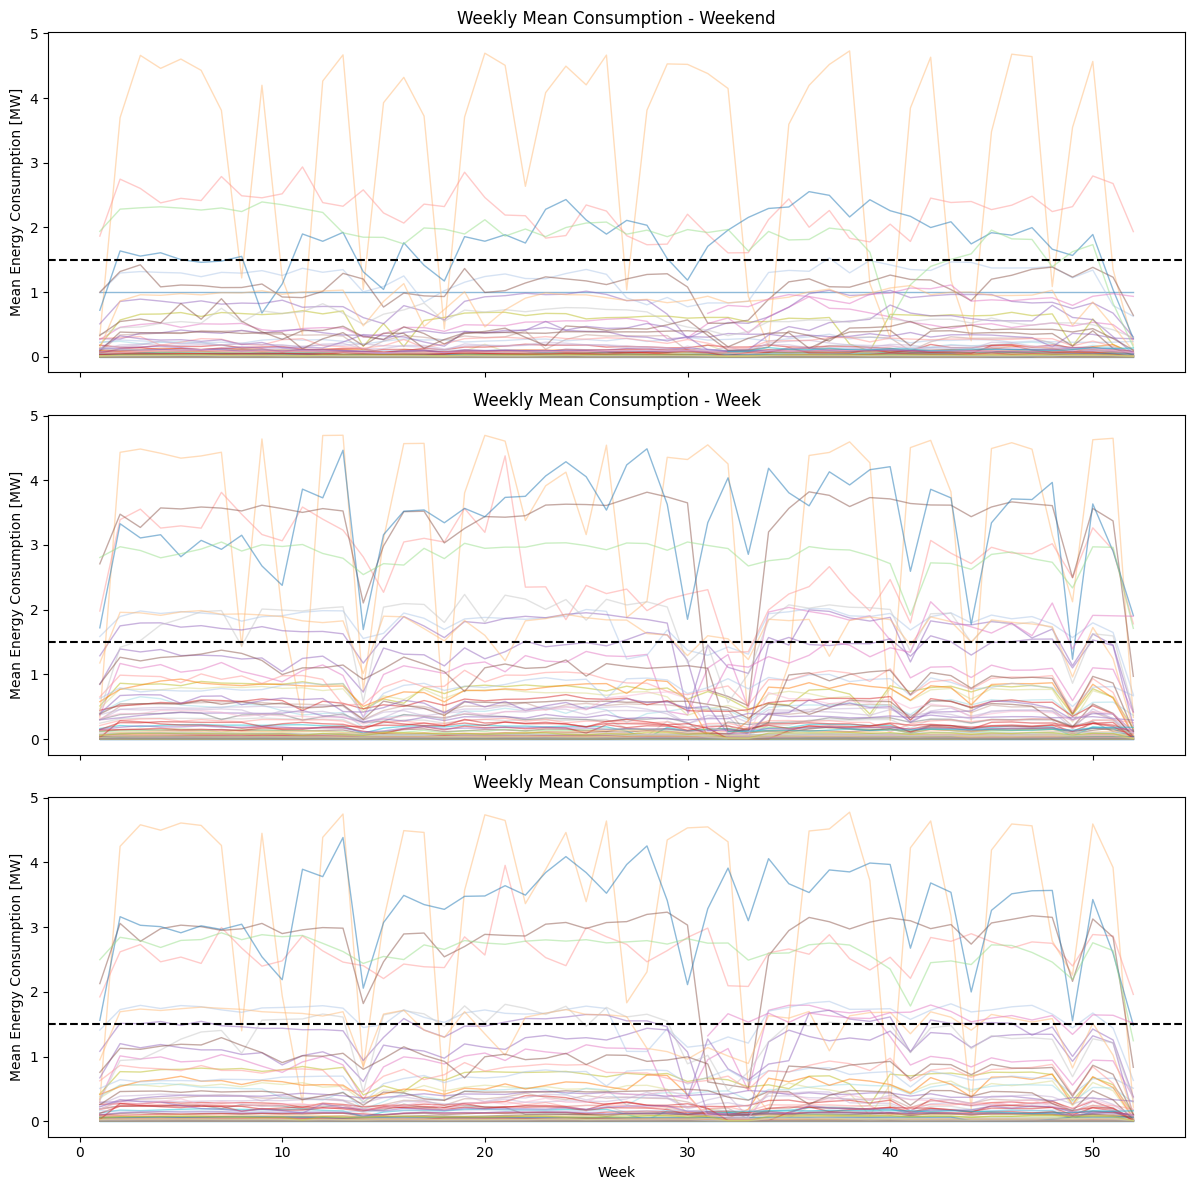

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True, sharey=True)

periods = ["Weekend", "Week", "Night"]
colors = plt.cm.tab20.colors  # general colors for customers

# Create a stable color mapping to customers excluding special_customers
all_customers = combined_df['CustomerName'].unique()
regular_customers = [cust for cust in all_customers if cust not in special_customers_es]
color_mapping = {customer: colors[i % len(colors)] for i, customer in enumerate(regular_customers)}

for i, period in enumerate(periods):
    subset = combined_df[combined_df["Period"] == period]
    for customer, group in subset.groupby("CustomerName"):
        if customer in special_customers_es:
            axs[i].plot(
                group["Week"],
                group["MeanConsumption"],
                label=customer,
                color='red',
                alpha=2,
                linewidth=10,
                zorder=5  # to plot on top
            )
        else:
            axs[i].plot(
                group["Week"],
                group["MeanConsumption"],
                label=customer,
                color=color_mapping[customer],
                alpha=0.5,
                linewidth=1
            )

    axs[i].axhline(y=1.5, color="black", linestyle="--", label="Threshold")
    axs[i].set_title(f"Weekly Mean Consumption - {period}")
    axs[i].set_ylabel("Mean Energy Consumption [MW]")

axs[-1].set_xlabel("Week")

# Optional legend: Place outside plot area clearly
handles, labels = axs[0].get_legend_handles_labels()

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # add space for legend
plt.show()


In [19]:
data_without_special_customers_it = data_it.drop(columns = special_customers_it)
data_without_special_customers_it["MeanConsumption"] = data_without_special_customers_it[normal_customers_it].mean(axis=1)
df_without_special_customers_it = data_without_special_customers_it.drop(columns = normal_customers_it)

data_without_special_customers_es = data_es.drop(columns = special_customers_es)
data_without_special_customers_es["MeanConsumption"] = data_without_special_customers_es[normal_customers_es].mean(axis=1)
df_without_special_customers_es = data_without_special_customers_es.drop(columns = normal_customers_es)

In [20]:
plot_aggregated_consumption_day(df_without_special_customers_it, ['DayYear','Year'], 'Mean Hourly Power Demand per Month')
plot_aggregated_consumption_day(df_without_special_customers_es, ['DayYear','Year'], 'Mean Hourly Power Demand per Month')

In [21]:
plot_aggregated_consumption(df_it, ["Month", 'Year'], 'Mean Hourly Power Demand per Month')
plot_aggregated_consumption(df_es, ["Month", 'Year'], 'Mean Hourly Power Demand per Month')

In [22]:
plot_aggregated_consumption(df_without_special_customers_it, ["Month", 'Year'], 'Mean Hourly Power Demand per Month')
plot_aggregated_consumption(df_without_special_customers_es, ["Month", 'Year'], 'Mean Hourly Power Demand per Month')

----------